<a href="https://colab.research.google.com/github/kavyajeetbora/modern_geospatial_stack/blob/master/notebooks/DuckDB_in_Jupyter_Notebooks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DuckDB in Jupyter Notebooks
A streamlined workflow for SQL analysis with DuckDB and Jupyter

## Library Import and Configuration

In [49]:
!pip install --quiet duckdb
!pip install --quiet jupysql
!pip install --quiet duckdb-engine
!pip install --quiet pandas
!pip install --quiet matplotlib
!pip install -q osmnx
!pip install -q pydeck

In [50]:
import duckdb
import pandas as pd
import geopandas as gpd
import shapely
import osmnx as ox
import pydeck as pdk
# No need to import sqlalchemy or duckdb_engine
#  JupySQL will use SQLAlchemy to auto-detect the driver needed based on your connection string!

# Import jupysql Jupyter extension to create SQL cells
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


We configure jupysql to return data as a Pandas dataframe and have less verbose output

In [51]:
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

## Connecting to DuckDB
Connect jupysql to DuckDB using a SQLAlchemy-style connection string. You may either connect to an in memory DuckDB, or a file backed db.

In [52]:
%sql duckdb:///:memory:
# %sql duckdb:///path/to/file.db

In [53]:
%%sql
INSTALL httpfs;
INSTALL spatial;

Empty DataFrame
Columns: [Success]
Index: []

## Downloading Builings in small area

In [54]:
W,S,E,N =  72.824548,19.19574,72.869386,19.231531

W,S,E,N = 72.8457167244,19.1174666804,72.8505208832,19.1231406236

In [71]:
%%time

%%sql
LOAD spatial;
LOAD httpfs;

COPY (
    SELECT
        id,
        level,
        height,
        ST_GeomFromWkb(geometry) AS geometry
    FROM read_parquet('s3://overturemaps-us-west-2/release/2024-06-13-beta.0/theme=buildings/type=*/*', filename=true, hive_partitioning=1)
    WHERE
        bbox.xmin > 72.8457167244
        AND bbox.xmax < 72.8505208832
        AND bbox.ymin > 19.1174666804
        AND bbox.ymax < 19.1231406236
) TO 'buildings_mumbai.geojson'
WITH (FORMAT GDAL, DRIVER 'GeoJSON', SRS 'EPSG:4326');

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

CPU times: user 3min 2s, sys: 1.61 s, total: 3min 3s
Wall time: 2min 59s


Empty DataFrame
Columns: [Success]
Index: []

In [72]:
%%sql
LOAD spatial;
LOAD httpfs;

COPY (
    SELECT
        id,
        ST_GeomFromWkb(geometry) AS geometry
    FROM read_parquet('s3://overturemaps-us-west-2/release/2024-06-13-beta.0/theme=transportation/type=*/*', filename=true, hive_partitioning=1)
    WHERE
        bbox.xmin > 72.8457167244
        AND bbox.xmax < 72.8505208832
        AND bbox.ymin > 19.1174666804
        AND bbox.ymax < 19.1231406236
) TO 'transportation_mumbai.geojson'
WITH (FORMAT GDAL, DRIVER 'GeoJSON', SRS 'EPSG:4326');

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Empty DataFrame
Columns: [Success]
Index: []

In [74]:
def create_map(W,S,E,N, geojson_file=None):
    bbox_geom = shapely.geometry.box(W,S,E,N)
    boundary_json = eval(gpd.GeoSeries(bbox_geom).to_json())

    boundary_layer = pdk.Layer(
        "GeoJsonLayer",
        boundary_json,
        opacity=1,
        stroked=True,
        filled=False,
        get_line_color=[100, 0, 0]
    )
    if geojson_file is not None:
        layer = pdk.Layer(
            "GeoJsonLayer",
            geojson_file,
            opacity=1,
            stroked=True,
            filled=True,
            get_fill_color=[100, 200, 0],
            get_line_color=[0,100,0],
            pickable=True
        )
        layers = [boundary_layer, layer]
    else:
        layers = [boundary_layer]


    C = bbox_geom.centroid
    view_state = pdk.ViewState(latitude=C.y, longitude=C.x, zoom=11, bearing=0, pitch=45)
    # Render

    r = pdk.Deck(layers=layers, initial_view_state=view_state, tooltip = True)
    return r

In [76]:
trans_gdf = gpd.read_file("buildings_mumbai.geojson")
trans_gdf["geom_type"] = trans_gdf["geometry"].apply(lambda x:x.geom_type)
trans_gdf_lines = trans_gdf[trans_gdf["geom_type"]=='Point']
trans_gdf_lines.shape

(0, 5)

CPU times: user 104 ms, sys: 54 ms, total: 158 ms
Wall time: 103 ms


<Axes: >

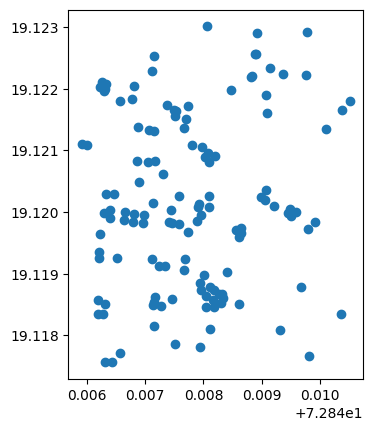

In [67]:

%%time
#ax = gpd.read_file("buildings_mumbai.geojson").plot(color='red')
trans_gdf_lines.plot()

In [77]:
%%time
buildings_gdf = gpd.read_file("buildings_mumbai.geojson").fillna("Na")
print(buildings_gdf.shape[0])
#buildings_gdf = buildings_gdf.sample(1000)
geojson = eval(buildings_gdf.to_json())

379
CPU times: user 237 ms, sys: 5.01 ms, total: 242 ms
Wall time: 241 ms


In [78]:
Map = create_map(W,S,E,N, geojson_file=geojson)
Map

<IPython.core.display.Javascript object>

{
  "initialViewState": {
    "bearing": 0,
    "latitude": 19.120303652,
    "longitude": 72.84811880379999,
    "pitch": 45,
    "zoom": 11
  },
  "layers": [
    {
      "@@type": "GeoJsonLayer",
      "data": {
        "bbox": [
          72.8457167244,
          19.1174666804,
          72.8505208832,
          19.1231406236
        ],
        "features": [
          {
            "bbox": [
              72.8457167244,
              19.1174666804,
              72.8505208832,
              19.1231406236
            ],
            "geometry": {
              "coordinates": [
                [
                  [
                    72.8505208832,
                    19.1174666804
                  ],
                  [
                    72.8505208832,
                    19.1231406236
                  ],
                  [
                    72.8457167244,
                    19.1231406236
                  ],
                  [
                    72.8457167244,
                    19.1174666804
                  ],
                  [
                    72.8505208832,
                    19.1174666804
                  ]
                ]
              ],
              "type": "Polygon"
            },
            "id": "0",
            "properties": {},
            "type": "Feature"
          }
        ],
        "type": "FeatureCollection"
      },
      "filled": false,
      "getLineColor": [
        100,
        0,
        0
      ],
      "id": "31a032e3-6e6c-4863-8b54-c7e19791b06e",
      "opacity": 1,
      "stroked": true
    },
    {
      "@@type": "GeoJsonLayer",
      "data": {
        "features": [
          {
            "geometry": {
              "coordinates": [
                [
                  [
                    72.8462797090666,
                    19.1175705396462
                  ],
                  [
                    72.8462750419897,
                    19.1175315353275
                  ],
                  [
                    72.8462531521692,
                    19.1175339018413
                  ],
                  [
                    72.8462503550855,
                    19.1175105256497
                  ],
                  [
                    72.8464428206382,
                    19.1174897180568
                  ],
                  [
                    72.8464502848665,
                    19.1175520985664
                  ],
                  [
                    72.8462797090666,
                    19.1175705396462
                  ]
                ]
              ],
              "type": "Polygon"
            },
            "id": "0",
            "properties": {
              "height": "Na",
              "id": "08b608b096b91fff02007266a3fd1497",
              "level": "Na"
            },
            "type": "Feature"
          },
          {
            "geometry": {
              "coordinates": [
                [
                  [
                    72.8471163,
                    19.1176167
                  ],
                  [
                    72.847101,
                    19.1175309
                  ],
                  [
                    72.8474355,
                    19.1174777
                  ],
                  [
                    72.8474508,
                    19.1175635
                  ],
                  [
                    72.8471163,
                    19.1176167
                  ]
                ]
              ],
              "type": "Polygon"
            },
            "id": "1",
            "properties": {
              "height": "Na",
              "id": "08b608b0968c9fff02006ea3d95745f6",
              "level": "Na"
            },
            "type": "Feature"
          },
          {
            "geometry": {
              "coordinates": [
                [
                  [
                    72.8461388795148,
                    19.1176552751777
                  ],
                  [
           

In [70]:
Map

<IPython.core.display.Javascript object>

{
  "initialViewState": {
    "bearing": 0,
    "latitude": 19.120303652,
    "longitude": 72.84811880379999,
    "pitch": 45,
    "zoom": 11
  },
  "layers": [
    {
      "@@type": "GeoJsonLayer",
      "data": {
        "bbox": [
          72.8457167244,
          19.1174666804,
          72.8505208832,
          19.1231406236
        ],
        "features": [
          {
            "bbox": [
              72.8457167244,
              19.1174666804,
              72.8505208832,
              19.1231406236
            ],
            "geometry": {
              "coordinates": [
                [
                  [
                    72.8505208832,
                    19.1174666804
                  ],
                  [
                    72.8505208832,
                    19.1231406236
                  ],
                  [
                    72.8457167244,
                    19.1231406236
                  ],
                  [
                    72.8457167244,
                    19.1174666804
                  ],
                  [
                    72.8505208832,
                    19.1174666804
                  ]
                ]
              ],
              "type": "Polygon"
            },
            "id": "0",
            "properties": {},
            "type": "Feature"
          }
        ],
        "type": "FeatureCollection"
      },
      "filled": false,
      "getLineColor": [
        100,
        0,
        0
      ],
      "id": "432d72dd-6a9a-4539-8307-d59da2234f18",
      "opacity": 1,
      "stroked": true
    },
    {
      "@@type": "GeoJsonLayer",
      "data": {
        "features": [
          {
            "geometry": {
              "coordinates": [
                [
                  [
                    72.8415958,
                    19.2108855
                  ],
                  [
                    72.841648,
                    19.210821
                  ],
                  [
                    72.8416804,
                    19.2108444
                  ],
                  [
                    72.8417456,
                    19.210764
                  ],
                  [
                    72.8417132,
                    19.2107405
                  ],
                  [
                    72.8417628,
                    19.2106793
                  ],
                  [
                    72.841889,
                    19.2107704
                  ],
                  [
                    72.8419755,
                    19.2106636
                  ],
                  [
                    72.8419416,
                    19.2106391
                  ],
                  [
                    72.8419557,
                    19.2106216
                  ],
                  [
                    72.8419221,
                    19.2105974
                  ],
                  [
                    72.841908,
                    19.2106148
                  ],
                  [
                    72.8418493,
                    19.2105724
                  ],
                  [
                    72.8419065,
                    19.2105018
                  ],
                  [
                    72.8419385,
                    19.2105249
                  ],
                  [
                    72.8419984,
                    19.210451
                  ],
                  [
                    72.8419664,
                    19.2104279
                  ],
                  [
                    72.8420135,
                    19.2103696
                  ],
                  [
                    72.8421309,
                    19.2104543
                  ],
                  [
                    72.8421065,
                    19.2104843
                  ],
                  [
                    72.8421537,
                    19.2105184
                  ],
                  [
                    72.8420634,
                    19.21063
 